# トークトリアル 7

# リガンドベーススクリーニング：機械学習

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Jan Philipp Albrecht and Jacob Gora

## このトークトリアルの目的

利用可能なデータソースがより大きくなるにつれ、医薬品探索、特にリガンドベースのバーチャルスクリーニングにおいて、機械学習（machine learning、ML）が盛り上がってきました。このトークトリアルでは、私たちの標的とするターゲット分子（EGFR）に対して新規な化合物の活性を予測するために、様々な教師あり機械学習（supervised ML）アルゴリズムを使用する方法について学習します。

## 学習の目標

* 機械学習で使用するために化合物をエンコードするための様々なフィンガープリント
* 様々な機械学習のアルゴリズムとその適用
* 機械学習モデルのパフォーマンスの評価

### 理論

* 様々なタイプのフィンガープリントの紹介
* 様々なタイプの教師あり機械学習アルゴリズム
* モデルのパフォーマンスの評価と測定

### 実践

* EGFR阻害剤となる可能性のある化合物を見つけるための、機械学習に基づくスクリーニングパイプラインの構築と評価

## レファレンス

* RdKitフィンガープリント：
    例）[2012年RDKit UGMでのG. Landrumによるプレゼンテーション](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)を参照してください
* 機械学習：
    * ランダムフォレスト（Random forest、RF）： [http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf](http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf)
    * サポートベクトルマシン（Support vector machines、SVM）： [https://link.springer.com/article/10.1007%2FBF00994018](https://link.springer.com/article/10.1007%2FBF00994018)
    * 人工ニューラルネットワーク（Artificial neural networks、ANN）： [https://www.frontiersin.org/research-topics/4817/artificial-neural-networks-as-models-of-neural-information-processing](https://www.frontiersin.org/research-topics/4817/artificial-neural-networks-as-models-of-neural-information-processing)
* パフォーマンス： 
    * [感度と特異度（Sensitivity_and_specificity (wikipedia)）](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
    * [Roc curve and AUC (wikipedia)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)
*  [*J. Med. Chem.*, 2017, 60, 474−485](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b01611) に基づく[B. MergetによるGitHubのNotebook](https://github.com/Team-SKI/Publications/tree/master/Profiling_prediction_of_kinase_inhibitors) も参照してください。

_____________________________________________________________________________________________________________________


## 理論

<img src="./images/ML_overview.png" width="200" align='right'>

機械学習をうまく適用するために必要となるものは、巨大な化合物データセット、化合物のエンコーディング、データセットの化合物ごとのラベル、そしてモデルを訓練するための機械学習アルゴリズムです。これらによって、新しい化合物の予測を行うことができます。

### データの準備

機械学習のために、化合物を特徴のリストに変換する必要があります。化合物の表現方法として、フィンガープリントがよく使われます。

このトークトリアルで使うフィンガープリントはRDKitに実装されているものです（より詳細な情報は[G. Landrumのプレゼンテーション](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf) で見ることができます）。  
* **maccs**: MACCS キー　166ビットの構造キー記述子（structural key descriptors）で、各ビットはSMARTSパターンに関連づけられています。
* **ecfp4** と　**ecfp6**: Extended-Connectivity Fingerprints (ECFPs) は化合物の特徴づけ、類似性検索、そして構造活性モデリングのためにデザインされた円形トポロジカルフィンガープリント（circular topological fingerprints）です。ECFPの最も重要なパラメータは最大直径とフィンガープリントの長さです。直径（diameter）と呼ばれるパラメータは、各原子について考慮する円形状の近傍の最大の直径を明示します。ここでは２つの直径、４と６があります。長さ（length）のパラメータはビット文字列表現の長さを明示します。デフォルトの長さは2048です。
* **torsion**: Torsion Fingerprint Deviation (TFD) は、クエリ分子と、非環状の結合（acyclic bond）と環系（ring system）を考慮して生成した配座群からトーションフィンガープリント（Torsion Fingerprint）を抽出、重み付けし、そして比較します。
* **rdk5**: rdk5は経路に基づくフィンガープリント（path based fingerprint)です。パスフィンガープリントは、分子グラフの全ての直線的なフラグメントを与えられたサイズまで網羅的に列挙し、これらのフラグメントを固定長ビットベクトルにハッシュ化することで生成されます。

### 機械学習 （Machine Learning、ML）

機械学習は次の用途に使うことができます（[scikit-learn page](http://scikit-learn.org/stable/)も参照してください）。

* **（教師あり）分類**：あるオブジェクト（object）がどのカテゴリーに属しているかを明らかにする（最近傍、ナイーブベイズ、ランダムフォレスト、サポートベクトルマシン、・・・）
* 回帰：オブジェクトに関連づけられた連続値の特徴量の予測
* （教師なし）クラスタリング：類似のオブジェクトを各セットに自動的にグループ化（ **トークトリアル5**　参照)

#### 教師あり学習

学習アルゴリズムは訓練データの中のパターンを見つけることでルールを作成します。
<img src="./images/RF_example.png" width="250" align='right'>
* **ランダムフォレスト（Random Forest、RF）**：多数の決定木（decision tree）により平均化された予測を出します。  
* **サポートベクトルマシン（Support Vector Machines (SVM)）**: SVMはカーネルトリックと呼ばれる入力を高次元の特徴空間に暗にマッピングする手法を使って、非線形の分類を効率的に実行することができます。オブジェクトの関数としてマージンを最大化するというアイデアに基づいた分類です。

    <img src="./images/ANN_wiki.png" width="150" align='right'>
* **人工ニューラルネットワーク（Artificial neural networks、ANNs）**：ANNは生物学的な脳の神経をゆるくモデル化した人工神経（artificial neuron）と呼ばれる連結されたユニットあるいはノードの集まりに基づいています。生物学的な脳のシナプスの様に、各結合は一つの人工神経からもう一方へとシグナルを伝達することができます。シグナルを受け取った人工神経は、そのシグナルを処理し、結合する別の人工神経へとシグナルを送ります。（図はWikipediaより）
 
#### 妥当性検査手法（Validation strategy）：k分割交差検証

* このモデル妥当性評価テクニックは反復的な方法でデータセットを２つのグループに分けます。  
    * トレーニングデータセット：モデルの訓練を行う既知のデータセット
    * テストデータセット：作成したモデルのテストを実施する未知のデータセット
    * この過程をk回繰り返す
    
* この検証の目標は過学習（over-fitting）として知られる問題に注意するために、モデルが一度も見たことのないデータを予測する性能をテストし、モデルの汎化性能を評価することです。

#### 性能評価
<img src="./images/FP_TP_fig.png" width="250" align='right'>

* **感度（Sensitivity）**、または真陽性（true positive rate）： TPR = TP/(FN+TP)
* **特異度（Specificity）**、または真陰性（true negative rate）： TNR = TN/(FP + TN)
* **精度（Accuracy）**、または真度（trueness）: ACC = (TP + TN)/(TP + TN + FP + FN)
* **ROC曲線**、受信者操作特性曲線（receiver operating characteristic curve、ROC-curve）：
    * 分類器（classifier）の診断性能を図解するプロット図
    * 感度を特異度に対してプロットします。
* **AUC**、ROC曲線の下の面積（Area Under the roc Curve）：  
    * 分類器がランダムに選択した正例を負例よりも高くランクづけする確率を表現します。
    * 0から１の値をとり、高い方がより良い値です。

In [1]:
# インポート文
# 一般的な項目：
import pandas as pd
import numpy as np

# RDKit：
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.AllChem import GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.Chem import MACCSkeys
from rdkit.DataStructs import ConvertToNumpyArray

# sklearn：
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
# from sklearn.manifold import MDS

# matplotlib:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# seaborn:
import seaborn as sns

RDKit WARNING: [10:15:34] Enabling RDKit 2019.09.1 jupyter extensions


### データの準備

ここではEGFR（Epidermal growth factor receptor）キナーゼのデータを扱います。

データを取り扱う前にまず、作業を行うデータフレームの作成に役立つ２つの関数を定義します。
最初の関数は分子のフィンガープリントを計算するもので `calculate_fp` と名付けます。フィンガープリントの選択肢は次です。  
* maccs
* ecfp4 と ecfp6
* torsion
* rdk5 

In [2]:
def calculate_fp(mol, method='maccs', n_bits=2048):
    # mol = Chem molecule object
    # 与えられたビットの数と手法で化合物のフィンガープリントを計算する関数
    if method == 'maccs':
        return MACCSkeys.GenMACCSKeys(mol)
    if method == 'ecfp4':
        return GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits, useFeatures=False)
    if method == 'ecfp6':
        return GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits, useFeatures=False)
    if method == 'torsion':
        return GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=n_bits)
    if method == 'rdk5':
        return RDKFingerprint(mol, maxPath=5, fpSize=1024, nBitsPerHash=2)

２番目の関数を使うことで次の列が追加されたデータフレームを作成することができます：

* moleculeオブジェクトとしての分子（SMILES文字列から作成）
* 選択した手法のPythonオブジェクトとしてのフィンガープリント（ここではMACCs）
* 選択したフィンガープリント手法のビットベクトルのバイナリ表記

したがって、パラメータが２つあります。一つは、正しいSMILES表記を格納する「smiles」という名前の列と、フィンガープリントの長さを保持するデータフレームです。２番目の引数はMACCSフィンガープリント以外の手法を選択した場合に使用します。

In [3]:
def create_mol(df_l, n_bits):
    # SMILES文字列から分子を構築
    # mol列を生成：molオブジェクトを返し、失敗した場合はNoneを返す
    df_l['mol'] = df_l.smiles.apply(Chem.MolFromSmiles)
    # 化合物フィンガープリントをフィンガープリントオブジェクトとして格納する列を生成
    df_l['bv'] = df_l.mol.apply(
        # 各化合物についてラムダ関数「calculate_fp」を適用
        lambda x: calculate_fp(x, 'maccs', n_bits)
    )
    # np.array をフィンガープリントのビットベクトルを保持するために割り当て(np = numpy)
    df_l['np_bv'] = np.zeros((len(df_l), df_l['bv'][0].GetNumBits())).tolist()
    df_l.np_bv = df_l.np_bv.apply(np.array)
    # フィンガープリントオブジェクトをNumpuArrayに変換しnp_bvに格納
    df_l.apply(lambda x: ConvertToNumpyArray(x.bv, x.np_bv), axis=1)

### データの読み込み

さて、データを読み込み、実際の作業を始めましょう。**トークトリアル 2**で取得したcsvファイルを、重要な列とともにデータフレームに読み込みます：

* CHEMBL-ID
* 対応する化合物のSMILES値
* pIC50

In [4]:
# 先のトークトリアルのデータを読み込む
df = pd.read_csv('../data/T2/EGFR_compounds_lipinski.csv', delimiter=';', index_col=0)
# 先頭行をみる
print(df.shape)
print(df.info())

(4523, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4523 entries, 0 to 5427
Data columns (total 10 columns):
molecule_chembl_id      4523 non-null object
units                   4523 non-null object
IC50                    4523 non-null float64
smiles                  4523 non-null object
pIC50                   4523 non-null float64
MW                      4523 non-null float64
HBA                     4523 non-null int64
HBD                     4523 non-null int64
LogP                    4523 non-null float64
rule_of_five_conform    4523 non-null object
dtypes: float64(4), int64(2), object(4)
memory usage: 388.7+ KB
None


### データを分類

各化合物を活性あるいは不活性として分類する必要があるので、pIC50値を使います。
* pIC50 = -log10(IC50) 
* IC50はin-vitroの阻害が50%になるモル濃度（mol/L）を表します。
* pIC50のデータを離散化（活性と不活性に分類）するのによく用いられるカットオフ値は6.3で、私たちの実験でもこの値を使います。
* 文献上ではpIC50値５から７までの範囲でいくつか他にも活性のカットオフが提案されており、データポイントをとらない除外領域を定義しているものさえある、ということを言及しておきます。

これで、上で定義した関数を使って、化合物とそのフィンガープリントを生成し、どの化合物が活性で、どれが活性でないかを明示することができます。

In [5]:
# 不必要な列の削除
df_new=df.drop(['units', 'IC50'], axis=1)
# SMILESから化合物とフィンガープリントを作成
create_mol(df_new, 2048)
# 活性を格納する列を追加
df_new['active'] = np.zeros(len(df_new))

# pIC50が6.3より大きい全ての化合物に印をつける
df_new.loc[df_new[df_new.pIC50 >= 6.3].index, 'active'] = 1.0
print('actives: %d, inactives: %d' % (df_new.active.sum(), len(df_new)-df_new.active.sum()))

actives: 2555, inactives: 1968


In [6]:
df_new.head(3)

,molecule_chembl_id,smiles,pIC50,MW,HBA,HBD,LogP,rule_of_five_conform,mol,bv,np_bv,active
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,yes,<rdkit.Chem.rdchem.Mol object at 0x12a734a30>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,yes,<rdkit.Chem.rdchem.Mol object at 0x12a7359e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,yes,<rdkit.Chem.rdchem.Mol object at 0x12a735710>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


### 機械学習

以下では、我々の化合物を分類するためにいくつかの機械学習のアプローチを試します。テストするアプローチは以下です。
* ランダムフォレスト（Random Forest、RF）
* サポートベクトルマシン（Support Vector Machines、SVM）
* 人工ニューラルネットワーク（Artificial Neural Networks、ANNs）

加えて、結果について評価し議論します。始める前に、 `crossvalidation`という名前の関数を定義します。この関数は交差検証（クロスバリデーション）の手順を実行し、精度と感度、特異度といった指標を返します。

目標は過学習（over-fitting）として知られる問題に注意するために、モデルが一度も見たことのないデータを予測する性能をテストし、モデルの汎化性能を評価することです。

In [7]:
# 交差検証ループのための関数
def crossvalidation(model_l, df_l, n_folds=10):
    # 選択したモデル、データフレームそして分割（fold）数を与えると、この関数は交差検証を実行し、
    # 予測の精度、感度、特異度を返し、また、各分割（fold）について偽陽性率（fpr）、真陽性率（tpr）、ROC曲線も返します。
    
    # resultsベクトルを空にする
    results = []
    # k-分割交差検証のためにインデックスをシャッフルする
    kf = KFold(n_splits=n_folds, shuffle=True)
    # 各データポイントについてラベルを-1で初期化
    labels = -1 * np.ones(len(df_l))
    # 分割(fold)数についてループを回す
    for train_index, test_index in kf.split(df_l):
        # トレーニング
        # ビットベクトルとラベルをリストに変換
        train_x = df_l.iloc[train_index].bv.tolist()
        train_y = df_l.iloc[train_index].active.tolist()
        # モデルを適合させる
        model_l.fit(train_x, train_y)

        # テスト
        # ビットベクトルとラベルをリストに変換
        test_x = df_l.iloc[test_index].bv.tolist()
        test_y = df_l.iloc[test_index].active.tolist()
        # テストセットについて予測
        prediction_prob = model_l.predict_proba(test_x)[:, 1]
        # 各分割（fold）について予測したラベルを保存
        labels[test_index] = model_l.predict(test_x)

        # 性能評価（パフォーマンス）
        # 各分割（fold）についての偽陽性率（fpr）、真陽性率（tpr）、ROC曲線
        fpr_l, tpr_l, _ = roc_curve(test_y, prediction_prob)
        roc_auc_l = auc(fpr_l, tpr_l)
        # 結果に追加
        results.append((fpr_l, tpr_l, roc_auc_l))

    # 全体の精度、感度、特異度を取得
    y = df_l.active.tolist()
    acc = accuracy_score(df_l.active.tolist(), labels)
    sens = recall_score(df_l.active.tolist(), labels)
    spec = (acc * len(y) - sens * sum(y)) / (len(y) - sum(y))
    return acc, sens, spec, results


もちろん、私たちはモデルの質を評価したいと思っています。したがって予測の精度と感度、特異度を知りたいと思います。加えていわゆるROC曲線に焦点を当てます。

コードを明確にし理解しやすくするために、結果をプロットする簡単な関数を作ります。

以下の点にひとまず焦点をあてます：　　
* 感度  
* 特異度  
* 精度  
* ROC曲線とAUC  

In [8]:
np.linspace(0.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
def print_results(acc, sens, spec, stat_res, main_text, file_name, plot_figure=1):
    plt.figure(plot_figure, figsize=(7, 7))
    cmap = cm.get_cmap('Blues')
    
    colors = [cmap(i) for i in np.linspace(0.3, 1.0, 10)]
    #colors = ["#3465A4"]
    for i, (fpr_l, tpr_l, roc_auc_l) in enumerate(stat_res):
        plt.plot(fpr_l, tpr_l, label='AUC CV$_{0}$ = {1:0.2f}'.format(str(i),roc_auc_l), lw=2, color=colors[i])
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
    plt.xlabel('False positive rate', size=24)
    plt.ylabel('True positive rate', size=24)
    plt.title(main_text, size=24)
    plt.tick_params(labelsize=16)
    plt.legend(fontsize=16)
    
    # Sプロットを保存 - テキストボックスを含めるためにbbox_inchesを使います。
    # https://stackoverflow.com/questions/44642082/text-or-legend-cut-from-matplotlib-figure-on-savefig?rq=1
    plt.savefig("../data/T7/" + file_name, dpi=300, bbox_inches="tight", transparent=True)
    
    plt.show()
    # AUCの平均を計算し出力します
    m_auc = np.mean([elem[2] for elem in r[3]])
    print('Mean AUC: {}'.format(m_auc))

    # 全体の精度、感度、特異度を表示します
    print('Sensitivity: {}\nAccuracy: {}\nSpecificity: {}\n'.format(acc, sens, spec))
    print('\n')

### ランダムフォレスト分類器

さて、ランダムフォレスト分類器からはじめます。まず最初にパラメータを設定します。その後で、モデルのクロスバリデーションを実行し、結果をプロットします。

In [10]:
# ランダムフォレストのパラメーターを設定
param = {'max_features': 'auto',
         'n_estimators': 2000,
         'criterion': 'entropy',
         'min_samples_leaf': 1}
modelRf = RandomForestClassifier(**param)

# 10分割で交差検証を実行
r = crossvalidation(modelRf, df_new, 10)

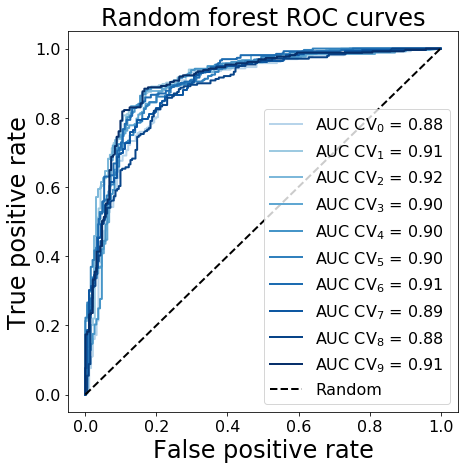

Mean AUC: 0.8997931471381779
Sensitivity: 0.83440194561132
Accuracy: 0.8806262230919765
Specificity: 0.7743902439024393





In [11]:
# AUCの結果をプロット
# r は精度（acc）、感度（sens）、特異度（spec）と結果を保持しています
print_results(r[0], r[1], r[2], r[3], 'Random forest ROC curves', 'rf_roc.png', 3)

我々のモデルは全ての指標について非常に良い値を示し、予測性能があるように見えます。

### サポートベクトル分類器

ここでは動径基底関数カーネル（Radial-basis function kernel（あるいは２乗指数カーネル（squared-exponentioal kernel）とも呼ばれます）によるサポートベクトルマシンを学習させます。より詳しい情報は [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html) を参照してください。

In [12]:
# モデルを明示
modelSvm = svm.SVC(kernel='rbf', C=1, gamma=0.1, probability=True)

# 10分割交差検証を実行
r = crossvalidation(modelSvm, df_new, 10)

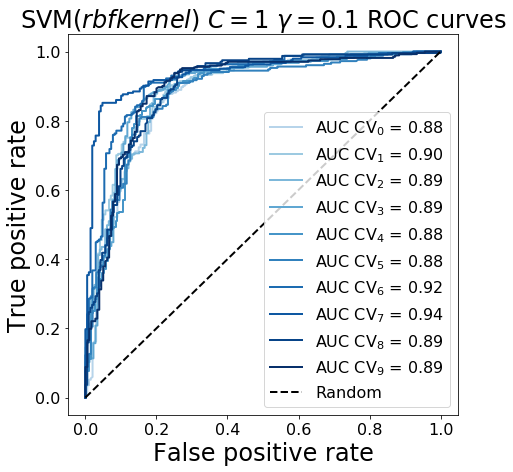

Mean AUC: 0.8969024290217835
Sensitivity: 0.8441300022109219
Accuracy: 0.9056751467710372
Specificity: 0.7642276422764228





In [13]:
# 結果をプロット
print_results(r[0], r[1], r[2], r[3],
              'SVM$(rbf kernel)$ $C=1$ $\gamma=0.1$ ROC curves', 'svm_roc.png', 3)

### ニューラルネットワーク分類器

ここで試す最後のアプローチはニューラルネットワークモデルです。各層5つのニューロンをもつ３層のMLPClassifier (多層パーセプトロン分類器、Multi-layer Perceptron classifier)を学習させます。早期終了（early stopping）が明示的にFALSEに設定されていることに気づかれたかもしれません。これまでと同様、交差検証を実行し結果をプロットします。MLPに関するより詳細な情報は[sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)を参照してください。

In [14]:
# モデルを明示、デフォルトの活性化関数：relu
modelClf = MLPClassifier(solver='adam', 
                         alpha=1e-5, 
                         hidden_layer_sizes=(5, 3), 
                         random_state=1, early_stopping=False)

# 10分割交差検証を実行
r = crossvalidation(modelClf, df_new, 10)

/Users/macnakamura/.pyenv/versions/anaconda3-5.3.1/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/macnakamura/.pyenv/versions/anaconda3-5.3.1/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/macnakamura/.pyenv/versions/anaconda3-5.3.1/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/macnakamura/.pyenv/versions/anaconda3-5.3.1/envs/my-rdkit-env/lib/pyt

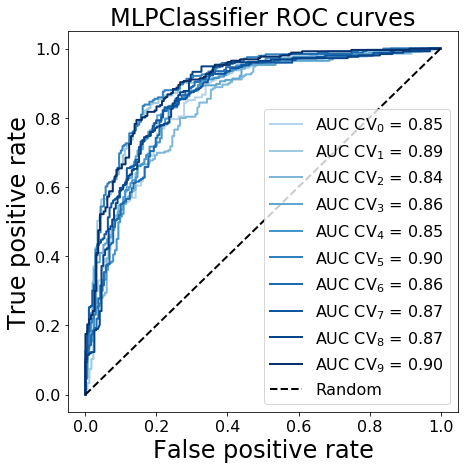

Mean AUC: 0.8686086737582928
Sensitivity: 0.8032279460535043
Accuracy: 0.8583170254403131
Specificity: 0.7317073170731707





In [15]:
# 結果をプロット
print_results(r[0], r[1], r[2], r[3], 'MLPClassifier ROC curves', 'mlp_roc.png', 3)

## ディスカッション

* 我々のデータッセットで最もパフォーマンスがよかったのはどのモデルで、それは何故でしょうか？
    * データセットに対して、３つのモデルはすべて（非常に）良いパフォーマンスでした。最も良いモデルはランダムフォレストとサポートベクトルマシンで、AUCの平均は90%でした。ニューラルネットワークはすこし低い結果で、AUCの平均は87%でした。（スクリプトを再度実行すると少し異なる結果となる可能性があることに注意してください。）
    * ランダムフォレストとサポートベクトルマシンのモデルが最も良いパフォーマンスを示したのにはいくつか理由があるかもしれません。我々のデータセットは、単純な決定木用の分類器（tree-like decisions）、あるいは動径基底関数でそれぞれ簡単に活性/不活性を分類できるものだったのかもしれません。したがって、この分類を行ううえでフィンガープリントにあまり複雑なパターンがなかったのかもしれません。
    * 人工ニューラルネットワーク（ANN）のパフォーマンスが少し悪かった理由としては、モデルを訓練するためのデータが単純に少なすぎたのかもしれません。
    * 加えて、モデルの評価のためには他の外部検証用データセット（validation set）を持っておくことを常におすすめします。
    
* MACCSを用いることは正しい選択だったのでしょうか？  
    * 明らかに、MACCSは分類が可能かどうかみるために、モデルの訓練と評価を行う出発点として良いものです。 
    * ですが、MACCSフィンガープリント（166ビット）は他のフィンガープリント（2048ビット）と比較してかなり短いので、異なるフィンガープリントを試し、検証のプロセスを繰り返した方が良いです。
    
### ここから次にどちらに進めば良いか？

* いくつかのモデルをうまく学習させることができました。
* 次のステップは、新奇なEGFR阻害剤となりうる可能性がある化合物を予測するために、これらのモデルを使って未知のスクリーニングデータセットの分類を行うことです。
* 巨大なスクリーニングデータセットの例として、例えば700万以上の化合物からなる[MolPort](https://www.molport.com/shop/database-download)があります。
* 我々のモデルを使ってMolPortの化合物をランク付けし、活性がある可能性が最も高いと予測された化合物群についてさらに研究を進めることができます。
* そのような適用例としては、S. RinikerとG. Landrumによって開発された　[TDT Tutorial](https://github.com/sriniker/TDT-tutorial-2014) も参照してみてください。新しい抗マラリア薬を見つけるために、融合モデルを訓練し [eMolecules](https://www.emolecules.com/) のスクリーニングを行なっています。

### クイズ

* バーチャルスクリーニングのためにどのように機械学習を適用することができますか？
* どのような機械学習アルゴリズムを知っていますか？
* 機械学習をうまく適用するための必要な前提条件は何ですか？